In [4]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import pickle
from math import cos, pi

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data    
import spacy
import seaborn as sns
import nltk
import itertools
import io
from imblearn.over_sampling import SMOTE
nlp = spacy.load('en')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device='cpu'
import read_preprocess
from models import DNN, dataset_csv
CUDA_LAUNCH_BLOCKING=1

from livelossplot import PlotLosses
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

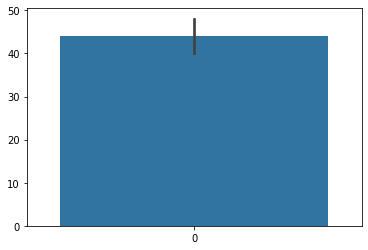

In [7]:
df = pd.read_csv('/home/user/Sarvesh/Baap_Product/AutoML_DL/Cement/train_concrete.csv')
sns.barplot(data=df['age'])

In [6]:
df['age'].value_counts()

28     342
3      113
7      104
56      66
14      48
90      44
100     40
91      20
180     19
270     13
365     10
360      2
1        2
120      1
Name: age, dtype: int64

In [147]:
class Discretize(BaseEstimator, TransformerMixin):
    def fit(self,X:pd.DataFrame):
        self.X = X
        self.X_num = self.X.select_dtypes(exclude=['category','uint8'])
        self.cols = self.X_num.columns.tolist()
        return self
    def transform(self,X):
        df_disc = pd.DataFrame()
        for col in self.cols:
            df_disc[col] = pd.cut(self.X_num[col],5,labels=['0_20','20_40','40_60','60_80','80_100'])
        df_disc = pd.get_dummies(df_disc,drop_first=False)
        
        return pd.concat([self.X,df_disc],axis=1)

In [148]:
frame = pd.read_csv('./adv_train.csv', index_col=False)
target = "Rating"
frame['Rating'].value_counts()

1    13317
2     4300
3     3256
4     1910
5     1337
Name: Rating, dtype: int64

In [149]:
def preprocess_sparse(frame_sparse):
    bad_na, good_na = [],[]
    for column in frame_sparse:
        if frame_sparse[column].isna().sum()/frame_sparse.shape[0] > 0.3:
            frame_sparse.append(column)
        elif frame_sparse[column].isna().sum()/frame_sparse.shape[0] <= 0.3 and frame_sparse[column].isna().any()==True:
            good_na.append(column)
        frame_sparse = frame_sparse.drop(bad_na,axis=1)
    print(f"Bad Frames: {len(bad_na)}")
    for col in good_na:
        frame_sparse[col] = frame_sparse[col].fillna(stats.stats.mode(frame_sparse[col])[0][0])
    return frame_sparse
frame = preprocess_sparse(frame)

Bad Frames: 0


In [150]:
glove_path = './glove.twitter.27B/glove.twitter.27B.25d.txt'
def load_glove(path):
    """
    creates a dictionary mapping words to vectors from a file in glove format.
    """
    with open(path) as f:
        glove = {}
        for line in f.readlines():
            values = line.split(' ')
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove[word] = vector
        return glove
    
def load_glove_embeddings(path, word2idx, embedding_dim=25):
    with open(path) as f:
        embeddings = np.zeros((len(word2idx), embedding_dim))
        for line in f.readlines():
            values = line.split(' ')
            word = values[0]
            index = word2idx.get(word)
            if index:
                vector = np.array(values[1:], dtype='float32')
                embeddings[index] = vector
        return torch.from_numpy(embeddings).float()

def tokenizer(text):
    text = text.replace('<br />',' ')
    text = text.replace('\x96',' ')
    text = nltk.word_tokenize(text)
    text = [w.lower() for w in text]
    return text

In [151]:
age = Discretize().fit_transform(frame[['Age']]).drop(['Age'],axis=1)
frame = frame.loc[:,'Rating':'unfav']
frame_sparse = frame.loc[:,'Rating':'Mostwatchedtvprogrammes_Weather']
frame_sparse = pd.concat((frame_sparse,age), axis=1)

frame_x_text = frame.loc[:,'fav':'unfav']

x_train_text = []
for i in frame_x_text['fav']+frame_x_text['unfav']:
    text = tokenizer(i)
    x_train_text.append(text)
    
# x_val_text = []
# for i in X_val_text_df['fav']+X_val_text_df['unfav']:
#     text = tokenizer(i)
#     x_val_text.append(text)
    
all_tokens = itertools.chain.from_iterable(x_train_text)
word_to_id = {token:idx for idx, token in enumerate(set(all_tokens))}

all_tokens = itertools.chain.from_iterable(x_train_text)
id_to_word = [token for idx, token in enumerate(set(all_tokens))]
id_to_word = np.asarray(id_to_word)

""" Load Train Embeddings """
glove = load_glove(glove_path)
train_embeddings = load_glove_embeddings(glove_path, word_to_id)

max_len = max([len(i) for i in x_train_text])
x_train_tokenized_sentences = np.array([[word_to_id[i] for i in j] for j in x_train_text])
# x_val_tokenized_sentences = np.array([[word_to_id[i] for i in j] for j in x_val_text])

# # Pad tokens with 0s
for i in range(len(x_train_tokenized_sentences)):
    a = x_train_tokenized_sentences[i]
    x_train_tokenized_sentences[i] = np.concatenate([a,np.zeros(max_len-len(a))])
    
# for i in range(len(x_val_tokenized_sentences)):
#     a = x_val_tokenized_sentences[i]
#     x_val_tokenized_sentences[i] = np.concatenate([a,np.zeros(max_len-len(a))])

In [152]:
x_train_tokenized_sentences

array([array([1957.,  728., 1624.,  963.,  384., 1192.,  170.,  974.,    0.,
        853., 1061.,  302.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.]),
       array([ 803., 1946.,  234., 1946., 1745., 1946.,  750.,  275., 1946.,
        452., 1946., 1526., 1827., 1946., 1615., 1946., 1333.,  209.,
       1946.,  744

In [153]:
frame_x_embedded = pd.DataFrame(x_train_tokenized_sentences.tolist())
frame_x_embedded.columns = [str(i) for i in frame_x_embedded.columns]

In [154]:
combined_dataset = pd.concat((frame_sparse,frame_x_embedded), axis=1)
combined_x = combined_dataset.loc[:,combined_dataset.columns != target]
combined_y = pd.DataFrame(combined_dataset[target],columns=[target])

In [155]:
smote_oversample = SMOTE()
combined_x, combined_y = smote_oversample.fit_resample(combined_x, combined_y)

In [156]:
combined_data = pd.concat((combined_x, combined_y),axis=1)
# combined_data = combined_data.sample(frac=1)
frame_x_sparse = combined_data.loc[:,'Gender_F':'Age_80_100']
frame_x_embedded = combined_data.loc[:,'0':'105']
frame_y = combined_data[target]

In [157]:
cc = combined_data.iloc[:,-107:-1]
cc = cc.reset_index(drop=True)
rows = {"0":[]}
for i in range(cc.shape[0]):
    temp = cc.loc[i,:]
    rows["0"].append(temp.values.tolist())
frame_x_embedded = pd.DataFrame(rows)

In [158]:
frame_x_embedded.columns=["fav_unfav"]

In [159]:
frame_sparse = pd.concat((frame_x_sparse,frame_x_embedded),axis=1)
X_train, X_val, y_train, y_val = train_test_split(frame_sparse.loc[:, frame_sparse.columns != target], frame_y, test_size=0.2, random_state=42)

In [160]:
X_train_stats = X_train.loc[:,'Gender_F':'Age_80_100']
X_train_stats.to_csv('./processed_splits/X_train_stats.csv', index=False)
X_train_text_df = X_train.loc[:,'fav_unfav']
X_train_text_df.to_csv('./processed_splits/X_train_text.csv', index=False)
X_val_stats = X_val.loc[:,'Gender_F':'Age_80_100']
X_val_stats.to_csv('./processed_splits/X_val_stats.csv', index=False)
X_val_text_df  = X_val.loc[:,'fav_unfav']
X_val_text_df.to_csv('./processed_splits/X_val_text.csv', index=False)
y_train_df = pd.DataFrame(y_train, columns=[target])-1 # Subtract one cos rating 1 to 5 instead of 0 to 4 
y_train_df.to_csv('./processed_splits/y_train.csv', index=False)
y_val_df  = pd.DataFrame(y_val, columns=[target])-1
y_val_df.to_csv('./processed_splits/y_val.csv', index=False)

/home/user/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.

/home/user/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.



In [161]:
X_train_stats.shape, y_train.shape, X_train_text_df.shape

((53268, 263), (53268,), (53268,))

In [162]:
X_val_text_df.shape

(13317,)

In [163]:
x_train_tokenized_sentences = X_train_text_df.values
for i in range(len(x_train_tokenized_sentences)):
    x_train_tokenized_sentences[i] = np.array(x_train_tokenized_sentences[i])
x_val_tokenized_sentences = X_val_text_df.values
for i in range(len(x_val_tokenized_sentences)):
    x_val_tokenized_sentences[i] = np.array(x_val_tokenized_sentences[i])

In [164]:
class DataReader(Dataset):
    def __init__(self, X_stats, x_train_tokenized_sentences, y, target):
        self.x1 = X_stats.values
        self.x2 = x_train_tokenized_sentences
        self.y = y[target].values
        
    def __getitem__(self, idx):
        x1 = self.x1[idx, :]
        x2 = self.x2[idx]
        y = self.y[idx]
        return x1, x2, y
    
    def __len__(self):
        return self.x2.shape[0]

In [165]:
class Classifier(nn.Module):
    def __init__(self, train_embeddings, dropout,dim):
        super().__init__()
        dim = int(dim)
        self.sparse_embeddings = nn.Embedding(263, 25)
        self.text_embeddings = nn.Embedding.from_pretrained(train_embeddings)
        self.emb_lin = nn.Linear(9225, dim*2)
        self.lin1 = nn.Linear(int(dim*2), int(dim/2)) # 64 = glove embedding(25) + sparse embedding(39)
        self.lin2 = nn.Linear(int(dim/2), int(dim/4))
        self.lin3 = nn.Linear(int(dim/4), 5)
#         self.bn1 = nn.BatchNorm1d(self.n_cont)
#         self.bn2 = nn.BatchNorm1d(200)
#         self.bn3 = nn.BatchNorm1d(70)
        self.dropout = nn.Dropout(dropout)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x_sparse, x_text):
        x = self.sparse_embeddings(x_sparse)
        x2 = self.text_embeddings(x_text)
        x = torch.cat([x, x2], 1)
        x = x.view(-1, 9225)
        x = self.emb_lin(x)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = F.relu(self.lin2(x))
        x = self.dropout(x)
        x = self.lin3(x)
        x = self.logsoftmax(x)
        return x

In [166]:
def cosine_lr(lr, epoch, step_size):
    lr = lr/2 * (cos(pi*(epoch%step_size)/step_size)+1)
    return lr

def train(trial):
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size',[64,128,256,512])
    params = {
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': 0
    }
    epochs = trial.suggest_int("epochs", 10, 250)
#     step_size = trial.suggest_int("step_size",5,100)
    highest_acc = 0
    dim = trial.suggest_categorical("layer_dims", [32,64,128,256,512])
    dropout = trial.suggest_uniform("dropout",0.1,0.6)
    net = Classifier(train_embeddings, dropout=dropout, dim=dim)
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    training_set = DataReader(X_train_stats, x_train_tokenized_sentences, y_train_df, target)
    train_loader = DataLoader(training_set, **params)
    validation_set = DataReader(X_val_stats, x_val_tokenized_sentences, y_val_df, target)
    val_loader = DataLoader(validation_set, **params)

    net = net.to(device)
    criterion = criterion.to(device)
    liveloss = PlotLosses()
    
#     low_lr = trial.suggest_loguniform("low_lr", 1e-8,1e-4)
#     cyclic_bool = trial.suggest_categorical("cyclic_bool",[True, False])
    plateau = 0
    for epoch in range(epochs):
        logs = {}
        if False:
            for a in optimizer.param_groups:
                lr = cosine_lr(lr, epoch, step_size) + low_lr
                a['lr'] = lr

        t_loss, a, acc = 0, 0, 0
        for x_sparse, x_text, y_train in train_loader:
            a+=1

            x_sparse, x_text, y_train = x_sparse.to(device, dtype = torch.int64), x_text.to(device, dtype = torch.int64), y_train.to(device)
            optimizer.zero_grad()
            net.train()
            y_pred = net(x_sparse, x_text)
            train_loss = F.cross_entropy(y_pred,y_train)
            t_loss += train_loss
            train_loss.backward()
            optimizer.step()
            acc += (y_pred.argmax(dim=1) == y_train).sum().float() / float(y_train.size(0))

#         print(acc/a)
        t_loss /= a
        if epoch%1 == 0:
            logs['CE Loss'] = t_loss / a
            logs['Accuracy'] = acc/a
            with torch.set_grad_enabled(False):
                test_loss, a, acc = 0, 0, 0
                for x_sparse_val, x_text_val, y_val in val_loader:
                    a += 1
                    x_sparse_val, x_text_val, y_val = x_sparse_val.to(device, dtype = torch.int64), x_text_val.to(device, dtype = torch.int64), y_val.to(device)
                    y_test_pred = net(x_sparse_val, x_text_val)
                    y_test_pred = torch.squeeze(y_test_pred)
                    test_loss += F.cross_entropy(y_test_pred,y_val)
                    acc += (y_test_pred.argmax(dim=1) == y_val).sum().float() / float(y_val.size(0))
            if (acc/a)>highest_acc: 
                plateau = 0
                highest_acc = acc/a
#                 torch.save(net.state_dict(),"./model_info/3_June_0.pth")
            else:
                plateau += 1
#             print(acc/a)
            test_loss /= a

#             logs['Val CE Loss'] = test_loss / a
#             logs['Val Accuracy'] = acc/a
#             logs['Highest Acc'] = highest_acc
#             print(f'[epoch]: {epoch}, [Train Loss]: {t_loss.item()}, [Val Loss]: {test_loss.item()}')
            if plateau>=epochs//3:
                break
#         liveloss.update(logs)
#         liveloss.send()
    return highest_acc

In [167]:
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(train, n_trials=25)

[I 2020-06-04 14:48:07,712] Finished trial#0 with value: 0.6719487309455872 with parameters: {'lr': 0.0001705750637645848, 'batch_size': 256, 'epochs': 197, 'layer_dims': 512, 'dropout': 0.16641997125852911}. Best is trial#0 with value: 0.6719487309455872.
[I 2020-06-04 14:48:19,755] Finished trial#1 with value: 0.22716806828975677 with parameters: {'lr': 0.002892827334811644, 'batch_size': 64, 'epochs': 10, 'layer_dims': 128, 'dropout': 0.20243223344441777}. Best is trial#0 with value: 0.6719487309455872.
[I 2020-06-04 14:48:42,283] Finished trial#2 with value: 0.24118924140930176 with parameters: {'lr': 0.0019385618422038513, 'batch_size': 512, 'epochs': 49, 'layer_dims': 256, 'dropout': 0.3241674866454065}. Best is trial#0 with value: 0.6719487309455872.
[I 2020-06-04 14:51:46,857] Finished trial#3 with value: 0.21350236237049103 with parameters: {'lr': 0.0786811962430303, 'batch_size': 256, 'epochs': 225, 'layer_dims': 256, 'dropout': 0.416387005309824}. Best is trial#0 with value:

In [ ]:
print("  Number of finished trials: ", len(study.trials))
trial = study.best_trial
trial.value

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
trial.params.items()

In [ ]:
y_train_df[target].value_counts().plot(kind="bar")



In [ ]:



x_train_stats = torch.from_numpy(X_train_stats.to_numpy()).long()
x_train_text  = 
X_val_stats   = 
X_val_text    = 
y_train       = 
y_val         =  


y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).long())

x_val = torch.from_numpy(X_test.to_numpy()).long()
y_val = torch.squeeze(torch.from_numpy(y_test.to_numpy()).long())

In [ ]:
# file_path = './imp_sparse_features_train.csv'
# target = 'Rating'
# split = 0.3
# x_train, x_val, y_train, y_val, tgt_type = read_preprocess.read_and_preprocess(file_path, target, split)
x_train = torch.from_numpy(x_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).long())

x_val = torch.from_numpy(x_val.to_numpy()).float()
y_val = torch.squeeze(torch.from_numpy(y_val.to_numpy()).long())

In [ ]:
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,40,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [ ]:
pca_transformer = PCA(n_components=35)
pca = pca_transformer.fit_transform(X_std)

In [ ]:
def train(lr, batch_size, epochs, x_train, y_train, x_val, y_val,step_size, tgt_type):
    print(y_train.shape[1])
    highest_acc = 0
    net = DNN(x_train.shape[1], tgt_type, [128,128,64,32],y_train.shape[1])
    
    if tgt_type=="regression":
        criterion = nn.MSELoss()
    else:
        criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    params = {
        'batch_size': 64,
        'shuffle': True,
        'num_workers': 0
    }
    training_set = dataset_csv(x_train, y_train)
    train_loader = DataLoader(training_set, **params)
    validation_set = dataset_csv(x_val, y_val)
    val_loader = DataLoader(validation_set, **params)
    
    
    net = net.to(device)
    criterion = criterion.to(device)
    
    for epoch in range(epochs):
        for a in optimizer.param_groups:
            lr = cosine_lr(lr, epoch, step_size) + 1e-5
            a['lr'] = lr
        t_loss, a, acc = 0, 0, 0
        log = {'y_train': [], 'y_val': [], 'y_pred': [], 'y_val_pred': []}
        for x_train, y_train in train_loader:
            a+=1
            x_train, y_train = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            net.train()
            y_pred = net(x_train)
            train_loss = criterion(y_pred, torch.max(y_train, 1)[1])
            t_loss += train_loss
            train_loss.backward()
            optimizer.step()
            acc += (y_pred.argmax(dim=1) == torch.max(y_train, 1)[1]).sum().float() / float(y_train.size(0))
        print(acc/a)
        t_loss /= a
        if epoch%1 == 0:
            with torch.set_grad_enabled(False):
                test_loss, a, acc = 0, 0, 0
                for x_val, y_val in val_loader:
                    a += 1
                    x_val, y_val = x_val.to(device),y_val.to(device)
                    y_test_pred = net(x_val)
                    y_test_pred = torch.squeeze(y_test_pred)
                    test_loss += criterion(y_test_pred, torch.max(y_val, 1)[1])
                    acc += (y_test_pred.argmax(dim=1) == torch.max(y_val, 1)[1]).sum().float() / float(y_val.size(0))
            if (acc/a)>highest_acc: 
                highest_acc = acc/a
                torch.save(net.state_dict(),"./model_info/14_may_1.pth")
            print(acc/a)
            test_loss /= a
            print(f'[epoch]: {epoch}, [Train Loss]: {t_loss.item()}, [Val Loss]: {test_loss.item()}')
        
        if tgt_type=="regression":
            if epoch%30==0:
                scaler_t = pickle.load(open('./model_info/scaler_t.pkl','rb'))
                y_0 = scaler_t.inverse_transform(log['y_train'])
                y_1 = scaler_t.inverse_transform(log['y_pred'])
                rmse = np.sqrt(mean_squared_error(y_0,y_1))
                print(rmse)
                y_0 = scaler_t.inverse_transform(log['y_val'])
                y_1 = scaler_t.inverse_transform(log['y_val_pred'])
                rmse = np.sqrt(mean_squared_error(y_0,y_1))
                print(rmse)
    return net, log

In [ ]:
trained_model, log = train(0.003, 512, 100, x_train, y_train, x_val, y_val, 10, tgt_type)

In [ ]:
# file_path = './upvotes/train.csv'
# target = 'Upvotes'

# X,y = read_and_preprocess_test(file_path, target, tgt_type)
ckpt_dir = "./model_info/14_may_1.pth"
def test(X,y, tgt_type, ckpt_dir):
    trained_model = DNN(x_train.shape[1], tgt_type, [128,128,64,32],y_train.shape[1])
    trained_model.load_state_dict(torch.load(ckpt_dir))
    trained_model
    x_test = X
    if y is not None:
        y_test = y
    trained_model.eval()
    y_pred = trained_model(x_test)
    y_pred = torch.squeeze(y_pred)
    return y_pred

In [ ]:
predictions = test(x_val,y_val,tgt_type,ckpt_dir)
enc = pickle.load(open('./model_info/OHE.pkl','rb'))
df = pd.DataFrame(columns=['gt','predictions'])
# df[['predictions']] = scaler_t.inverse_transform(df[['predictions']])

In [ ]:
gt = torch.max(y_val, 1)[1].detach().numpy()
df = pd.DataFrame(gt)
df

In [ ]:
df = pd.DataFrame(columns=['gt','predictions'])
df['gt'] = gt
df['predictions'] = predictions.argmax(dim=1)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df

In [ ]:
cm = pd.DataFrame(confusion_matrix(df['gt'], df['predictions']))
cm

In [ ]:
file_path = './CICIDS2017/combined_data_test.csv'
target = 'Label'
x_test, y_test = read_preprocess.read_and_preprocess_test(file_path, target, split)

x_test = torch.from_numpy(x_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).long())

In [ ]:
predictions = test(x_test,y_test,tgt_type,ckpt_dir)
enc = pickle.load(open('./model_info/OHE.pkl','rb'))
df = pd.DataFrame(columns=['gt','predictions'])
gt = torch.max(y_test, 1)[1].detach().numpy()
df = pd.DataFrame(gt)
df = pd.DataFrame(columns=['gt','predictions'])
df['gt'] = gt
df['predictions'] = predictions.argmax(dim=1)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df, pd.DataFrame(confusion_matrix(df['gt'], df['predictions']))

In [ ]:
pred.numpy()

In [ ]:
b = np.zeros((gt.size, gt.max()+1))
b[np.arange(gt.size),gt] = 1
gt2 = b

pred = predictions.argmax(dim=1).numpy()
b = np.zeros((pred.size,pred.max()+1))
b[np.arange(pred.size),pred] = 1
pred = b

In [ ]:
enc.inverse_transform(gt2)

In [ ]:
df['gt'] = enc.inverse_transform(gt2)
df['predictions'] = enc.inverse_transform(pred)
pred_df = pd.DataFrame(classification_report(df['gt'], df['predictions'], output_dict=True))
pred_df

In [ ]:
labels = df['gt'].unique().tolist()

In [ ]:
pd.DataFrame(confusion_matrix(df['gt'], df['predictions'],normalize = 'all'), index = labels,columns = labels)